# Time Series : Classical and ML Model Comparisons

Machine learning methods can be used for classification and forecasting on time series problems.

Before exploring machine learning methods for time series, it is a good idea to ensure you have exhausted classical linear time series forecasting methods. 

Classical time series forecasting methods may be focused on linear relationships, nevertheless, they are sophisticated and perform well on a wide range of problems, assuming that your data is suitably prepared and the method is well configured.

In this notebook, I am sharing a suite of classical methods for time series forecasting that one can test on their forecasting problems prior to exploring the machine learning methods.

#### This notebook demonstrates 4 different classical time series forecasting methods:

1. Autoregression (AR)
2. Autoregressive Integrated Moving Average (ARIMA)
3. Seasonal Autoregressive Integrated Moving-Average (SARIMA)
4. Facebook Prophet

#### From Machine Learning side, we will be focusing on the H2O open source algorithms.

1. H2OXGBoostRegressor
2. H2ODLEstimator

In this notebook, we'll be using the Walmart M5 Competition data. 
It's a multi time series data which consist of different items at different store/city/state location and we need to forecast the demand for next 28 days.

We'll be limiting our discussion for 100 items, 10 items from each of the 10 store.

### Let's Load some python packages

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import pickle
import datetime
import gc

### Let's Load the Data

In [7]:
def read_data():
    print('Reading files...')
    train = pd.read_csv('walmart_13_train.csv')
    print('Train has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
    test = pd.read_csv('walmart_13_test.csv')
    print('Test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
    return train, test

train, test = read_data()

Reading files...
Train has 1893870 rows and 9 columns
Test has 27720 rows and 9 columns


In [8]:
train.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date
0,HOBBIES_1_022_CA_1_evaluation,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,1,2,2011-01-02
1,HOBBIES_1_073_CA_1_evaluation,HOBBIES_1_073,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-02
2,HOBBIES_1_173_CA_1_evaluation,HOBBIES_1_173,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-02
3,HOBBIES_1_209_CA_1_evaluation,HOBBIES_1_209,HOBBIES_1,HOBBIES,CA_1,CA,1,4,2011-01-02
4,HOBBIES_1_307_CA_1_evaluation,HOBBIES_1_307,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-02


In [9]:
test.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date
0,HOBBIES_1_022_CA_1_evaluation,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,1914,0,2016-03-29
1,HOBBIES_1_073_CA_1_evaluation,HOBBIES_1_073,HOBBIES_1,HOBBIES,CA_1,CA,1914,0,2016-03-29
2,HOBBIES_1_173_CA_1_evaluation,HOBBIES_1_173,HOBBIES_1,HOBBIES,CA_1,CA,1914,0,2016-03-29
3,HOBBIES_1_209_CA_1_evaluation,HOBBIES_1_209,HOBBIES_1,HOBBIES,CA_1,CA,1914,2,2016-03-29
4,HOBBIES_1_307_CA_1_evaluation,HOBBIES_1_307,HOBBIES_1,HOBBIES,CA_1,CA,1914,0,2016-03-29


Let's check some basic info about our dataset

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893870 entries, 0 to 1893869
Data columns (total 9 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   day       int64 
 7   demand    int64 
 8   date      object
dtypes: int64(2), object(7)
memory usage: 130.0+ MB


Here, we have `id` as the unique identifier corresponding to one combination of item_id,dept_id,cat_id,store_id and state_id. We also have a day column here which indicates the training time day as integer. Then we have our `demand`  column which is the Target that we need to forecast.

In [11]:
print(f'Number of unique States      : {train.state_id.nunique()}')
print(f'Number of unique Stores      : {train.store_id.nunique()}')
print(f'Number of unique Categories  : {train.cat_id.nunique()  }')
print(f'Number of unique Items       : {train.item_id.nunique()}')
print(f'Number of unique Sale Prices : {train.id.nunique()}')
print(f'Unique States      : {train.state_id.unique()}')
print(f'Unique Stores      : {train.store_id.unique()}')
print(f'Unique Categories  : {train.cat_id.unique()}')
print(f'\nNo. of Days of Historical data in training : {train.day.nunique()}')
print(f'Forecast Horizon                           : {test.day.nunique()}')
print(f'Gap between train and test Horizon         : {test.day.min()-train.day.max()-1}')

Number of unique States      : 3
Number of unique Stores      : 10
Number of unique Categories  : 3
Number of unique Items       : 99
Number of unique Sale Prices : 990
Unique States      : ['CA' 'TX' 'WI']
Unique Stores      : ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Unique Categories  : ['HOBBIES' 'HOUSEHOLD' 'FOODS']

No. of Days of Historical data in training : 1913
Forecast Horizon                           : 28
Gap between train and test Horizon         : 0


As we can see, we have 10 different Walmart stores spread across three states viz. California, Texas and Wisconsin in the US and within these 10 stores we have 99 items for which we are given nearly 5 years of data and asked to forecast for next 28 days.

Let's look at the some of the items, how their sales have been over the training period.

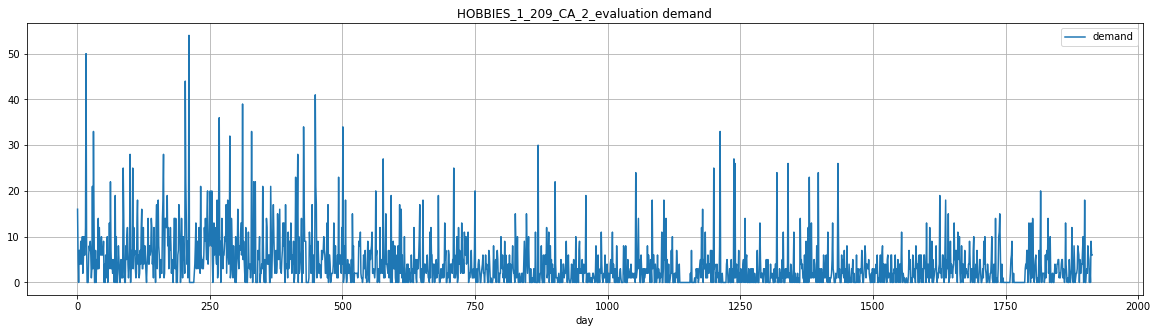

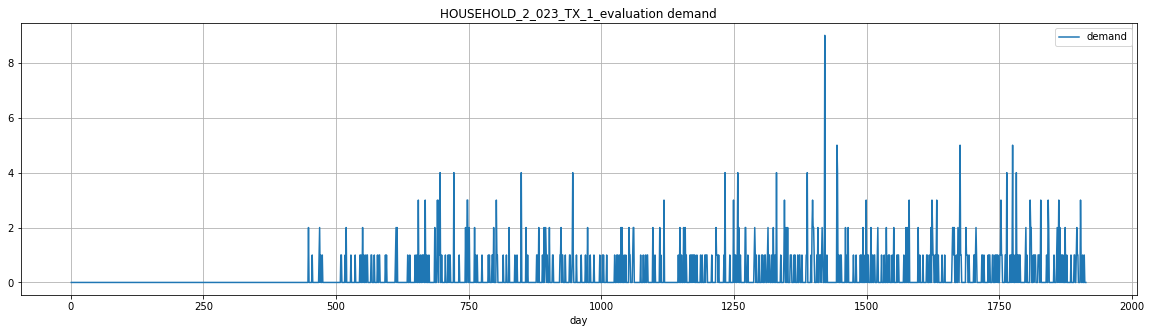

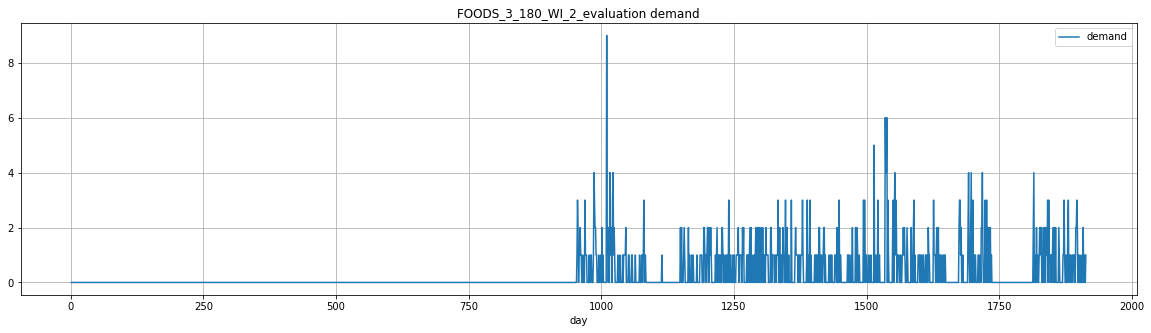

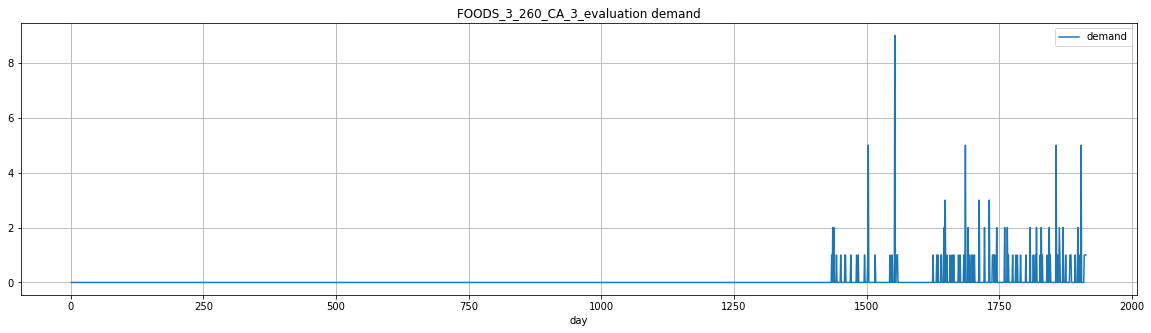

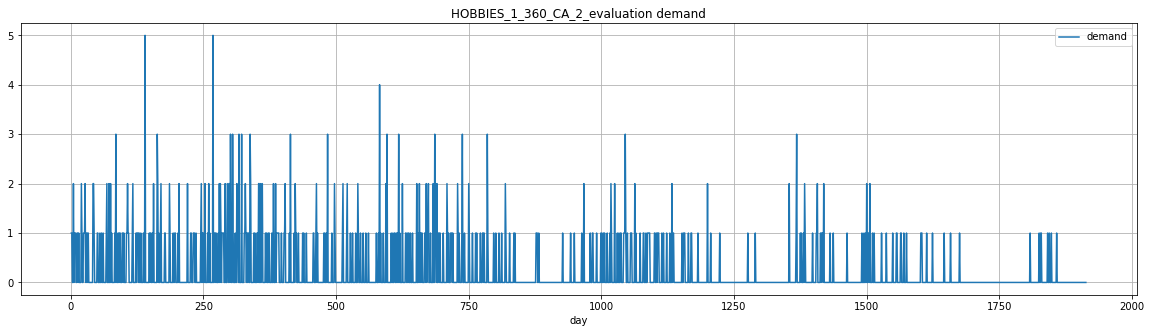

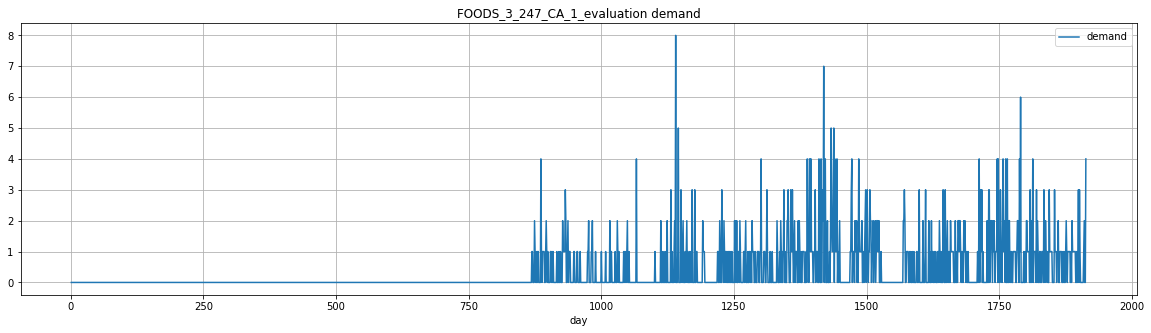

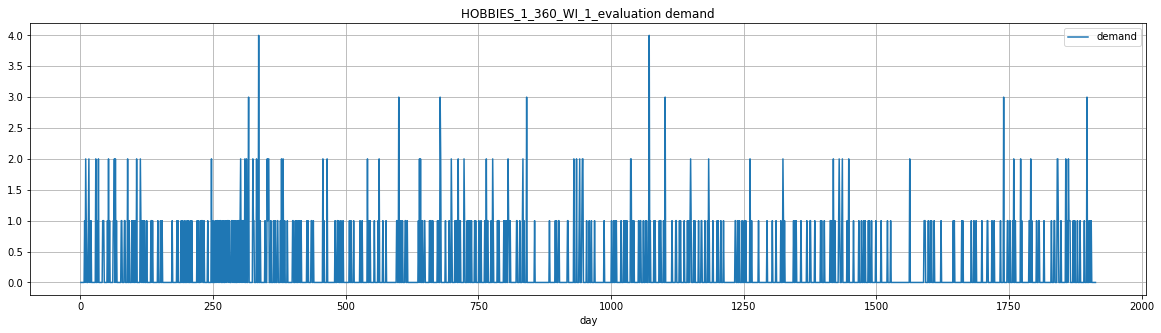

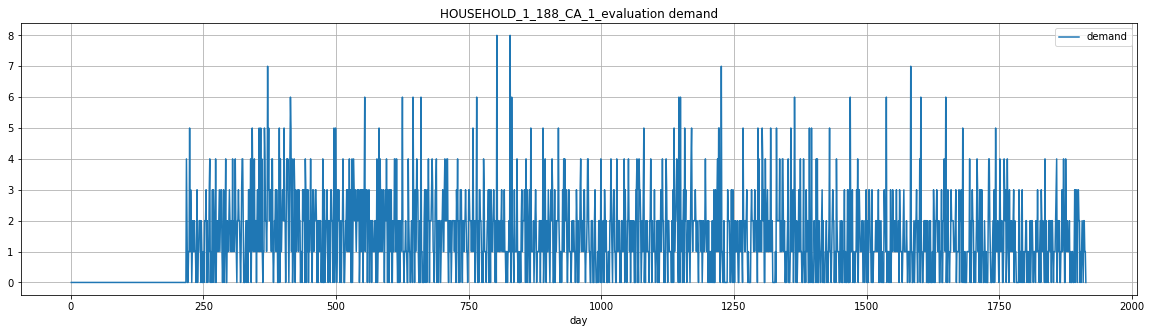

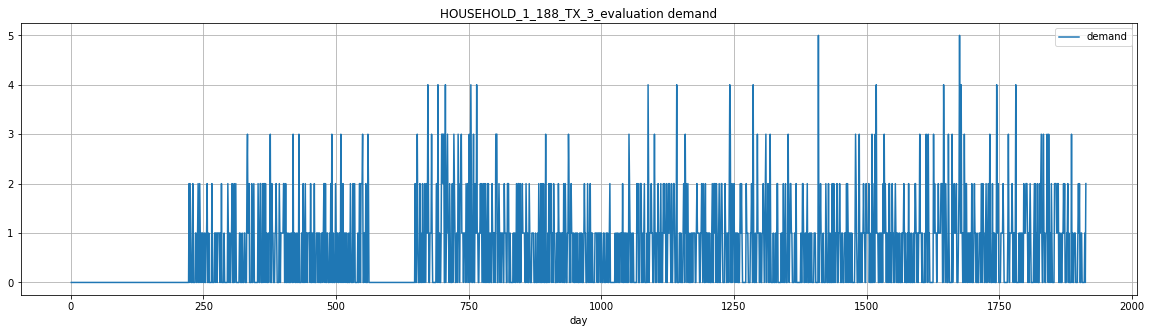

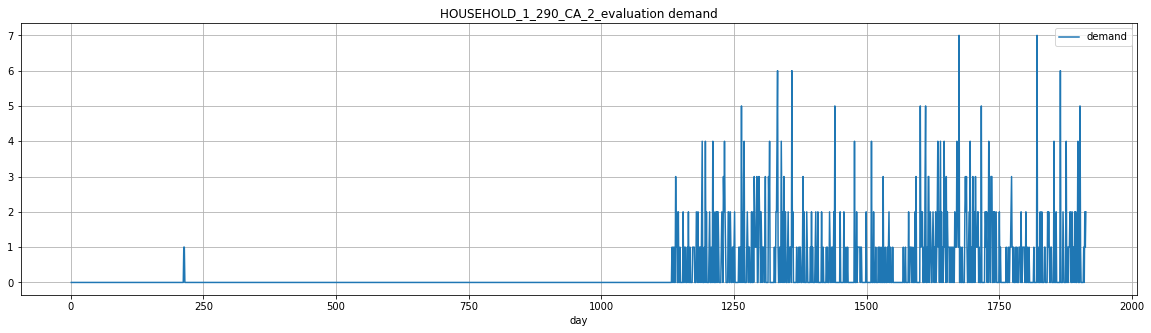

In [12]:
np.random.seed(42)
sample_items = np.random.choice(train['id'].unique().tolist(), 10)

for item in sample_items:
    train[train['id']==item].set_index('day')['demand'].plot(figsize=(20, 5))
    plt.grid()
    plt.legend(loc = 'best')
    plt.title(f'{item} demand')
    plt.show(block=False)

As we can see from above plot, demand follows a very intermittent pattern (zero demand days). We call these type of data as sparse time series. 


***Shall we begin!***

Let's Start with each of the approaches one by one

## Statistical Forecasting Techniques

### 1. Autoregression (AR)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.

The method is suitable for univariate time series without trend and seasonal components.

The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).

In [63]:
from statsmodels.tsa.ar_model import AutoReg

def fit_auto_reg(df, forecast_horizon):
    
    data = df[['day','demand']].reset_index(drop=True)
    
    model = AutoReg(data.set_index('day')['demand'], lags = forecast_horizon)
    model_fit = model.fit()
    
    yhat = model_fit.predict(forecast_horizon, len(data)+forecast_horizon)
    
    return yhat[-forecast_horizon:]

In [27]:
def plot_predictions_for_sample(pred_df, sample_list):
    
    for item in sample_list:

        train[(train['id']==item) & (train.day>1800)].set_index('day')['demand'].plot(figsize=(20, 5), 
                                                                 color='cornflowerblue', label='Train data')
        pred_df[pred_df['id']==item].set_index('day')['prediction'].plot(figsize=(20, 5), 
                                                                 color='orange', label='Predictions')
        pred_df[pred_df['id']==item].set_index('day')['demand'].plot(figsize=(20, 5), 
                                                                 color='green', label='Actuals')    
        plt.grid()
        plt.legend(loc = 'best')
        plt.title(f'{item} demand')
        plt.show(block=False)

In [74]:
item_list = []
item_pred = []
day_list = []

FORECAST_HORIZON = 28

for item in tqdm(train.id.unique()):
    item_list.extend([item]*FORECAST_HORIZON)
    day_list.extend([i for i in range(1914, 1914+FORECAST_HORIZON)])
    pred = fit_auto_reg(train[train.id==item][['day','demand']], FORECAST_HORIZON)
    item_pred.extend(pred)
    
arg_df = pd.DataFrame({'id':item_list, 'day': day_list, 'prediction': item_pred})
arg_df = arg_df.merge(test[['id','day','demand']], on=['id','day'])

100%|██████████| 990/990 [00:00<00:00, 296364.35it/s]


#### Let's see how our simplistic auto regression model have performed. 

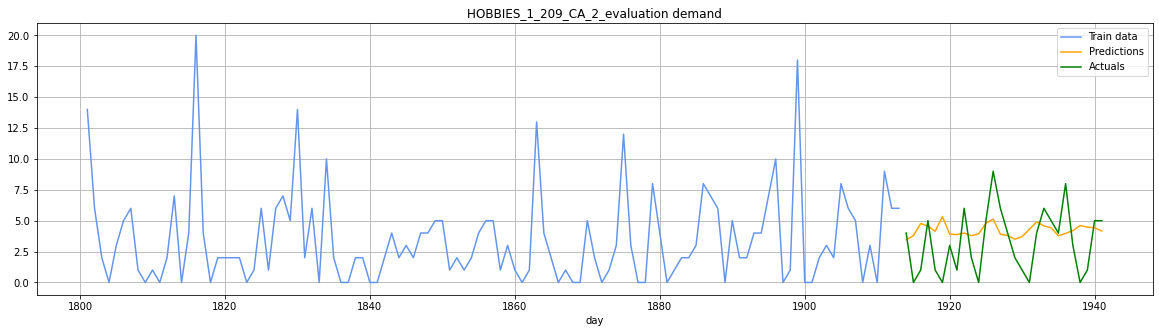

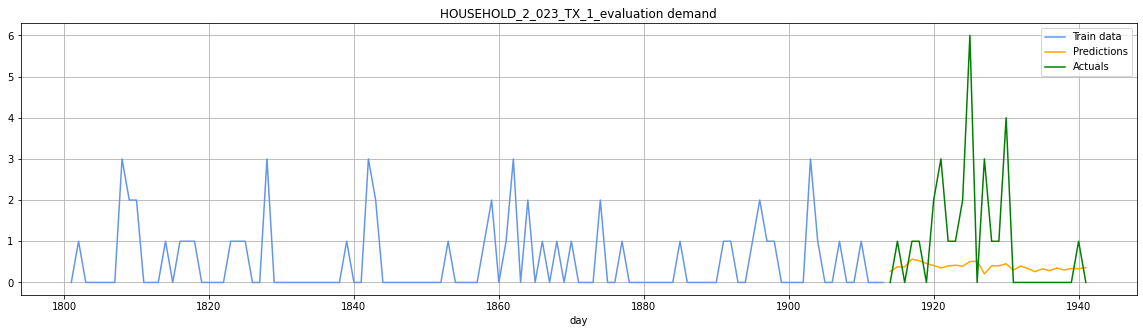

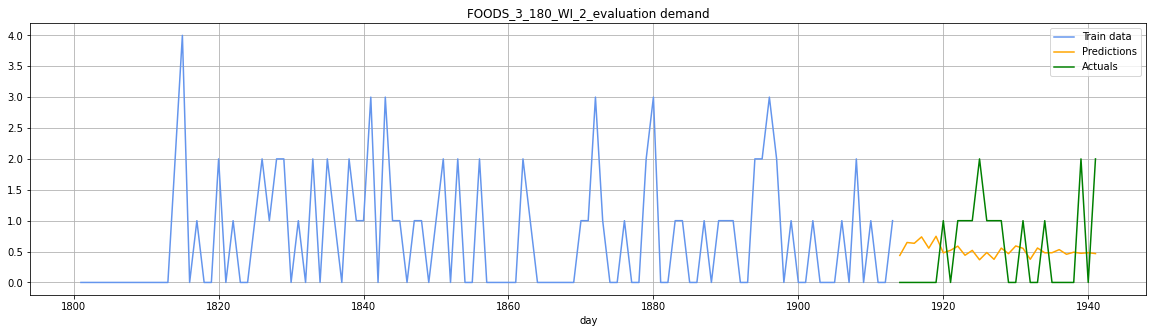

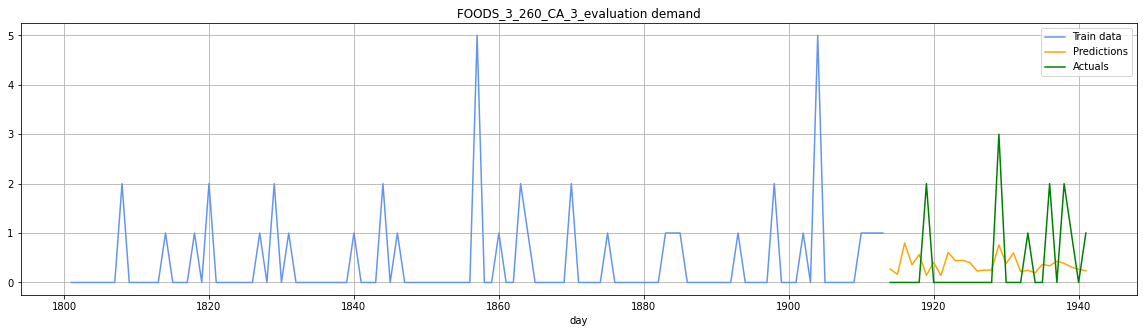

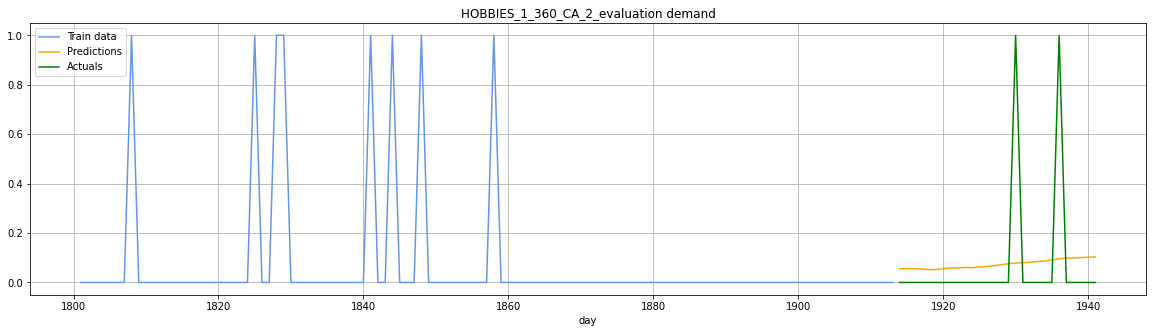

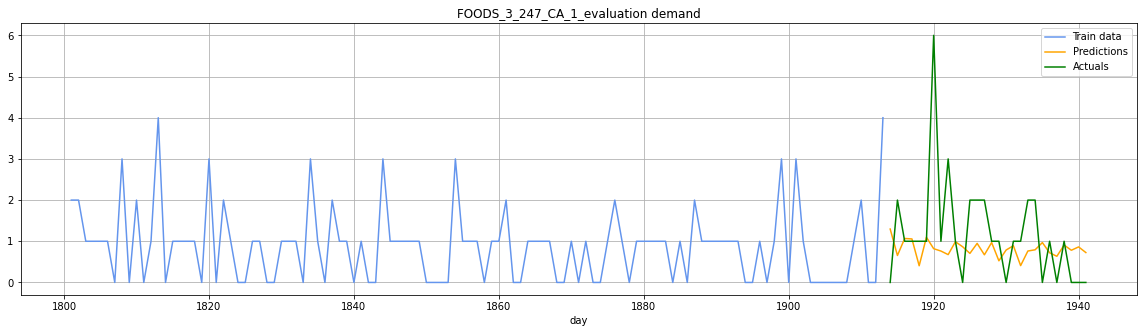

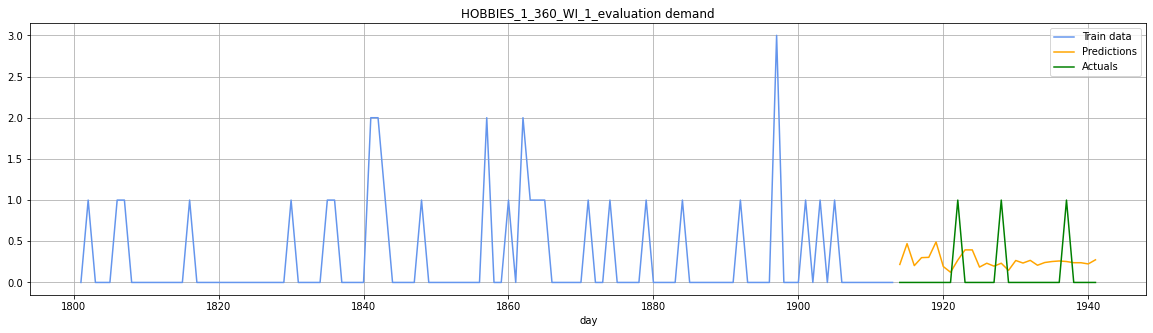

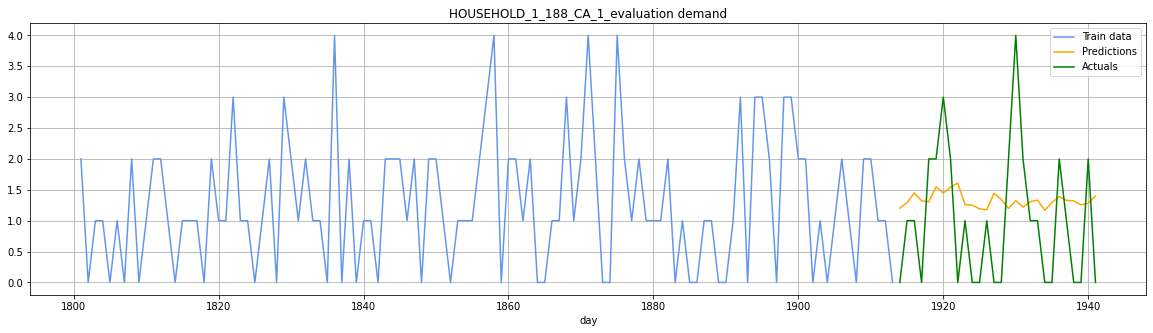

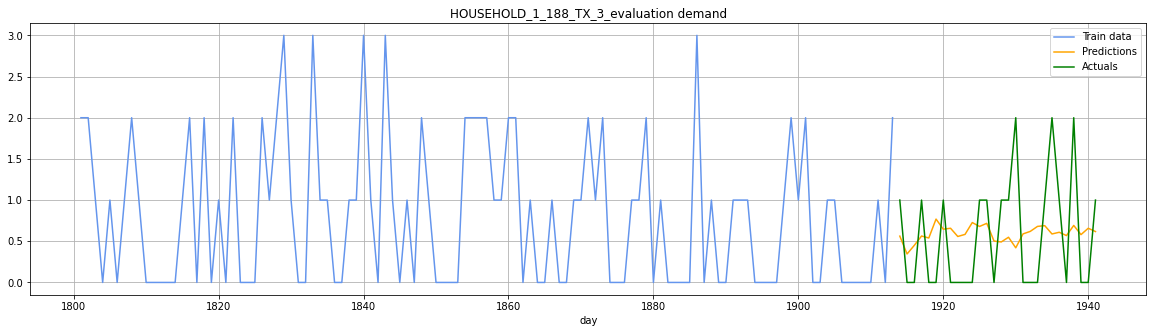

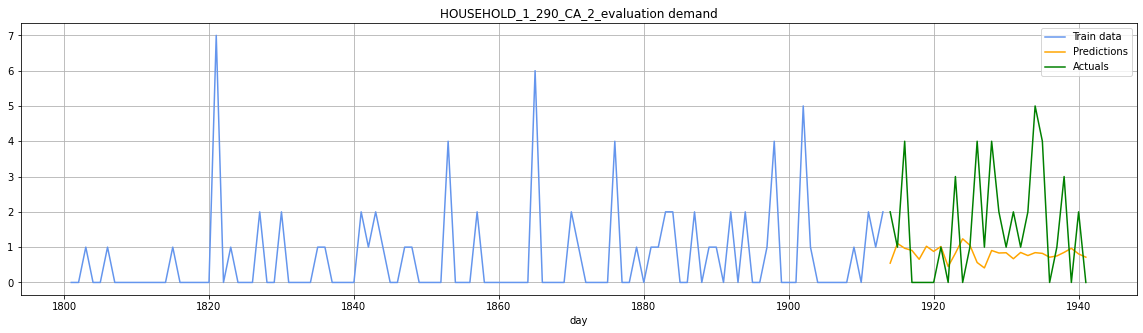

AutoRegression Model test MSE is 4.24 and RMSE is 2.06
AutoRegression Model test MSE for 10 sample is 1.74 and RMSE is 1.32


In [108]:
plot_predictions_for_sample(arg_df, sample_items)

error = mean_squared_error(arg_df['demand'], arg_df['prediction'])
print(f'AutoRegression Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

error = mean_squared_error(arg_df[arg_df.id.isin(sample_items)]['demand'], 
                           arg_df[arg_df.id.isin(sample_items)]['prediction'])
print(f'AutoRegression Model test MSE for 10 sample is {error:.3} and RMSE is {error ** 0.5:.3}')

#### Observations

1. From the above plots, it is clear that our model is not performing as per our expectations
2. The model is only able to predict around the mean levels and not able to capture the sparsity and peaks of individual time series
3. We need to train a separate model for each time series, this will pose challenges going forwards as we add more items to our historical data
4. Training separate models limit the model to capture inter time series patterns, as sales in store is not exclusive and dependent on other items

### 2. Autoregressive Integrated Moving Average (ARIMA)

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

The method is suitable for univariate time series with trend and without seasonal components.

In [101]:
from statsmodels.tsa.arima.model import ARIMA

def fit_auto_arima(df, forecast_horizon):
    
    data = df[['day','demand']].reset_index(drop=True)
    
    model = ARIMA(data.set_index('day')['demand'], order=(forecast_horizon, 1, 1))
    model_fit = model.fit()
    
    yhat = model_fit.predict(forecast_horizon, len(data)+forecast_horizon, typ='levels')
    
    return yhat[-forecast_horizon:]

In [103]:
%%time
for item in train.id.unique():
    pred = fit_auto_arima(train[train.id==item][['day','demand']], FORECAST_HORIZON)
    break

  0%|          | 0/990 [00:24<?, ?it/s]

CPU times: user 5min 38s, sys: 5min 38s, total: 11min 17s
Wall time: 24.4 s


One iteration takes nearly 25s, running it for 1000 items will take us approx 7 hrs, so we'll do it only for 10 sample items

In [106]:
item_list_arima = []
item_pred_arima = []
day_list_arima = []

FORECAST_HORIZON = 28

for item in tqdm(sample_items):
    
    item_list_arima.extend([item]*FORECAST_HORIZON)
    day_list_arima.extend([i for i in range(1914, 1914+FORECAST_HORIZON)])
    pred = fit_auto_arima(train[train.id==item][['day','demand']], FORECAST_HORIZON)
    item_pred_arima.extend(pred)
    
arima_df = pd.DataFrame({'id':item_list_arima, 'day': day_list_arima, 'prediction': item_pred_arima})
arima_df = arima_df.merge(test[['id','day','demand']], on=['id','day'], how='inner')

100%|██████████| 10/10 [05:26<00:00, 32.61s/it]


#### Let's see ARIMA model's performance

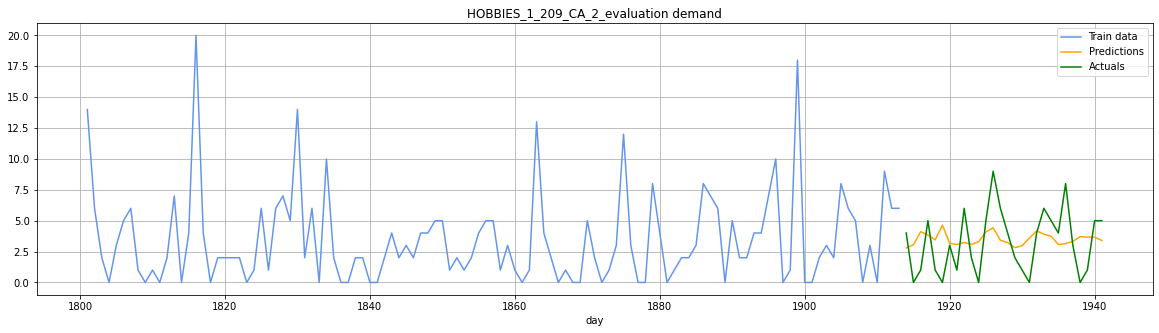

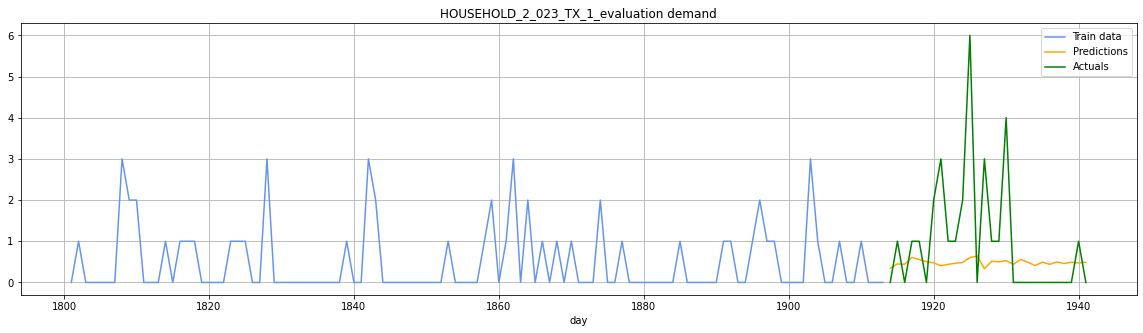

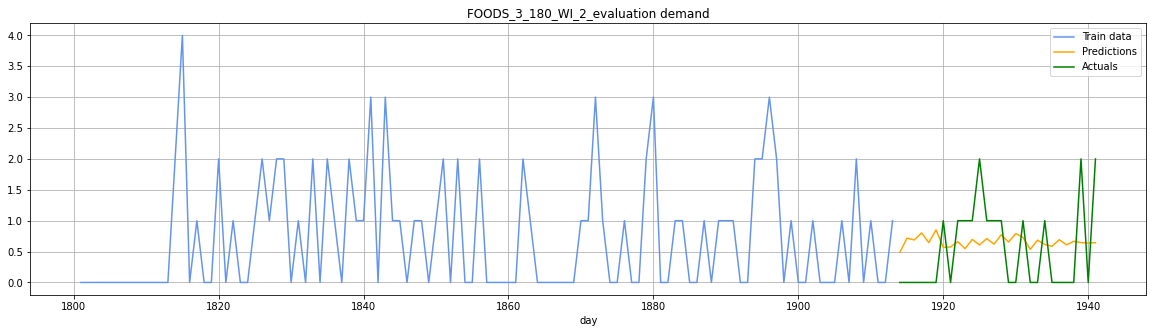

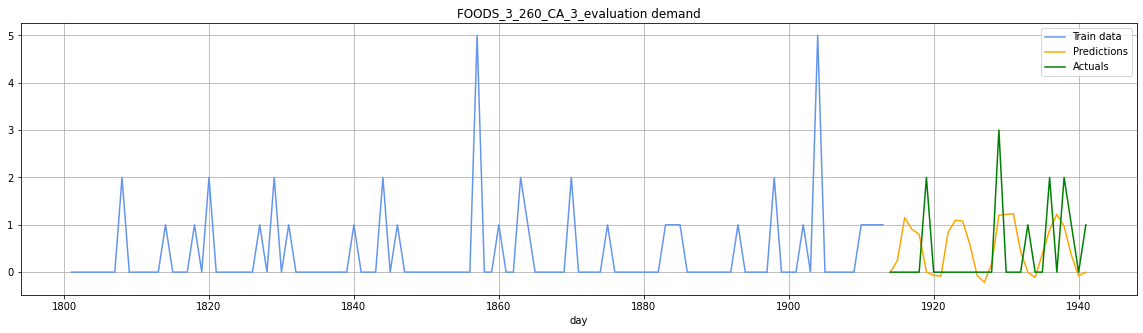

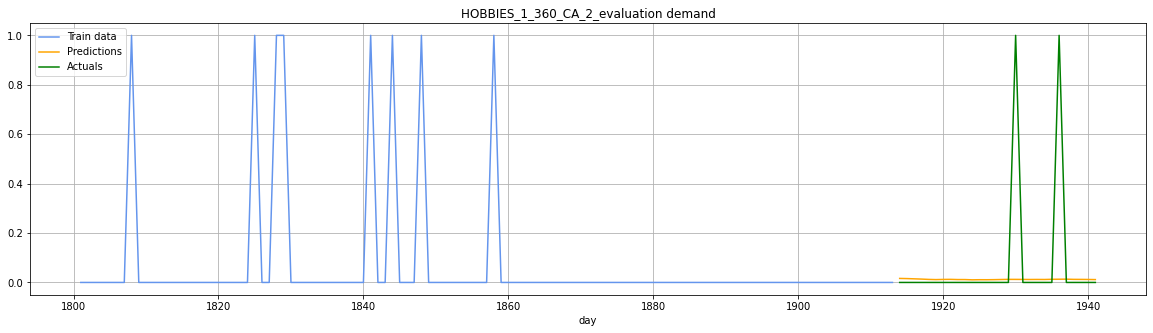

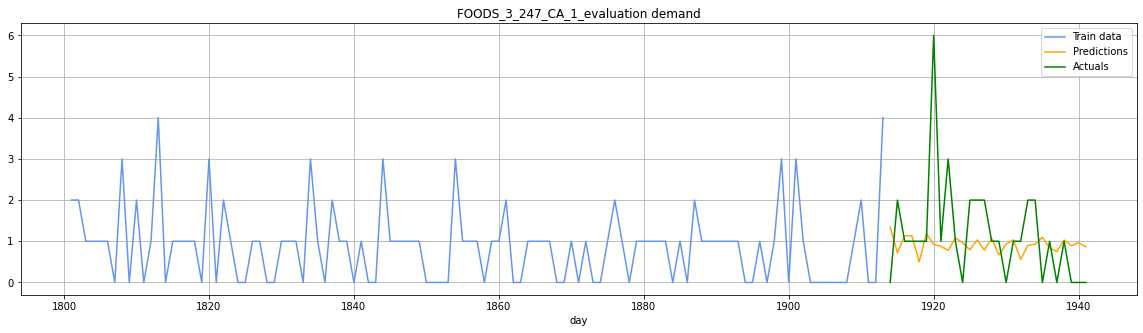

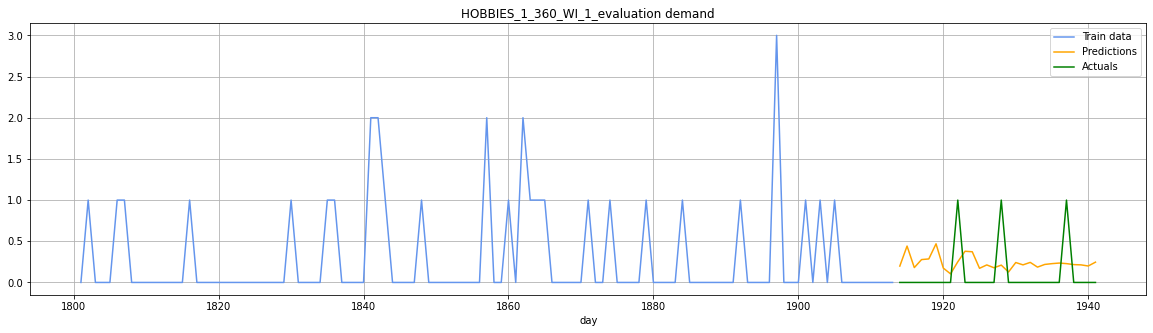

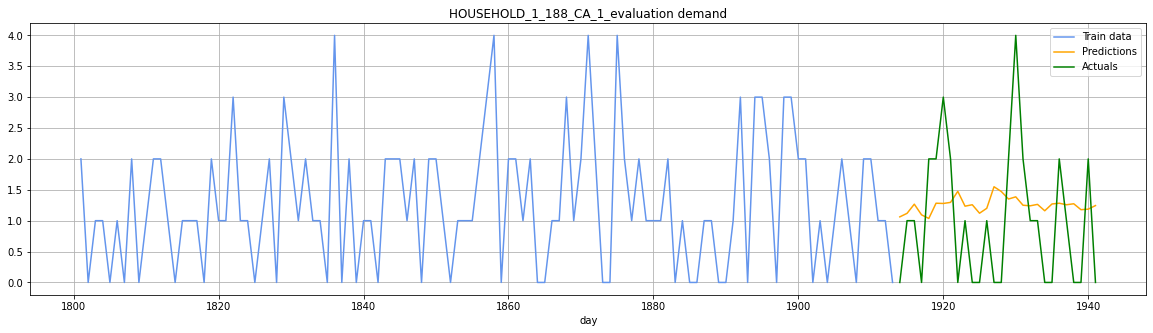

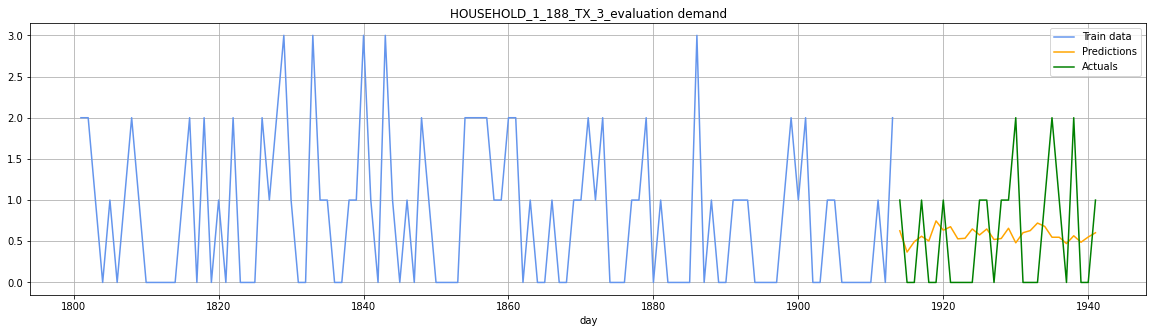

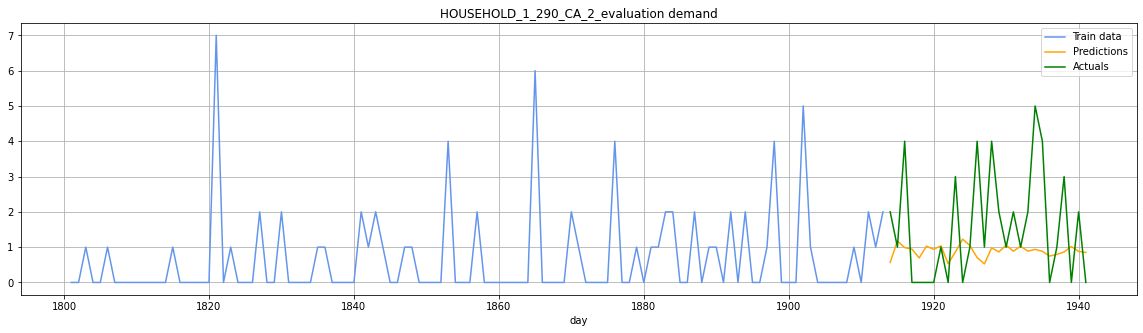

ARIMA Model test MSE is 1.63 and RMSE is 1.28


In [113]:
plot_predictions_for_sample(arima_df, sample_items)

error = mean_squared_error(arima_df['demand'], arima_df['prediction'])
print(f'ARIMA Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

#### Observations

1. We can see that ARIMA model has performed slightly better as compared to our AR model with improvement in both Mean Squared error and RMSE for the 10 samples.
2. The model is slightly able to account for the sparsity but overall prediction is still very much concentrated around the means levels.
3. Time taken to train an ARIMA model is significantly high as compared to that of a AR model. This limits the model's ability to scale as we add more items to our historical data.
4. Training separate models limit the model to capture inter time series patterns, as sales in store is not exclusive and dependent on other items

### 3. Seasonal Autoregressive Integrated Moving-Average (SARIMA)

The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.

In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_auto_sarima(df, forecast_horizon):
    
    data = df[['day','demand']].reset_index(drop=True)
    model = SARIMAX(data.set_index('day')['demand'], order=(forecast_horizon, 1, 1), 
                    seasonal_order=(1, 0, 0, 84))  # quaterly seasonality added for differntiation
    model_fit = model.fit(disp=False)
    
    yhat = model_fit.predict(forecast_horizon, len(data)+forecast_horizon, typ='levels')
    
    return yhat[-forecast_horizon:]

In [121]:
%%time
for item in train.id.unique():
    pred = fit_auto_sarima(train[train.id==item][['day','demand']], FORECAST_HORIZON)
    break

CPU times: user 2h 23min 15s, sys: 2h 15min 18s, total: 4h 38min 33s
Wall time: 7min 50s


One iteration of SARIMA takes nearly 8mins, running it for 1000 items will take us approx 135 hrs, so we'll do it only for a couple of items

In [122]:
item_list_sarima = []
item_pred_sarima = []
day_list_sarima = []

FORECAST_HORIZON = 28

for item in tqdm(sample_items[:2]):
    
    item_list_sarima.extend([item]*FORECAST_HORIZON)
    day_list_sarima.extend([i for i in range(1914, 1914+FORECAST_HORIZON)])
    pred = fit_auto_sarima(train[train.id==item][['day','demand']], FORECAST_HORIZON)
    item_pred_sarima.extend(pred)
    
sarima_df = pd.DataFrame({'id':item_list_sarima, 'day': day_list_sarima, 'prediction': item_pred_sarima})
sarima_df = sarima_df.merge(test[['id','day','demand']], on=['id','day'], how='inner')

100%|██████████| 2/2 [22:33<00:00, 676.95s/it]


#### Let's see SARIMA model's performance

In [125]:
error = mean_squared_error(sarima_df['demand'], sarima_df['prediction'])
print(f'SARIMA Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

SARIMA Model test MSE is 4.28 and RMSE is 2.07


#### Observations

1. Both SARIMA and ARIMA models have similar performance as per the plots. 
2. Time taken to train a SARIMA model is significantly high as compared to that of a AR/ARIMA model. This is not at all a model which can help a big store to forecast for all it's item.
3. Training separate models limit the model to capture inter time series patterns, as sales in store is not exclusive and dependent on other items

### 4. Facebook Prophet

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

The `Prophet()` object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The `fit()` function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations. This means we change the column names in the dataset. It also requires that the first column be converted to date-time objects, if they are not already.

In [38]:
from fbprophet import Prophet

def fit_fbprophet(df, forecast_horizon):
    
    data = df[['date','demand']].reset_index(drop=True)
    fstart = data['date'].max()
    
    data.columns = ['ds', 'y']
    
    model = Prophet()
    model_fit = model.fit(data)
    
    future = list()
    for i in range(1, forecast_horizon+1):
        future.append(fstart + timedelta(i))
    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    yhat = model.predict(future)['yhat']

    return yhat

In [43]:
item_list_fbp = []
item_pred_fbp = []
day_list_fbp = []

FORECAST_HORIZON = 28

for item in tqdm(sample_items):
    item_list_fbp.extend([item]*FORECAST_HORIZON)
    day_list_fbp.extend([i for i in range(1914, 1914+FORECAST_HORIZON)])
    pred = fit_fbprophet(train[train.id==item][['date','demand']], FORECAST_HORIZON)
    item_pred_fbp.extend(pred)
    
fbp_df = pd.DataFrame({'id':item_list_fbp, 'day': day_list_fbp, 'prediction': item_pred_fbp})
fbp_df = fbp_df.merge(test[['id','day','demand']], on=['id','day'])

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


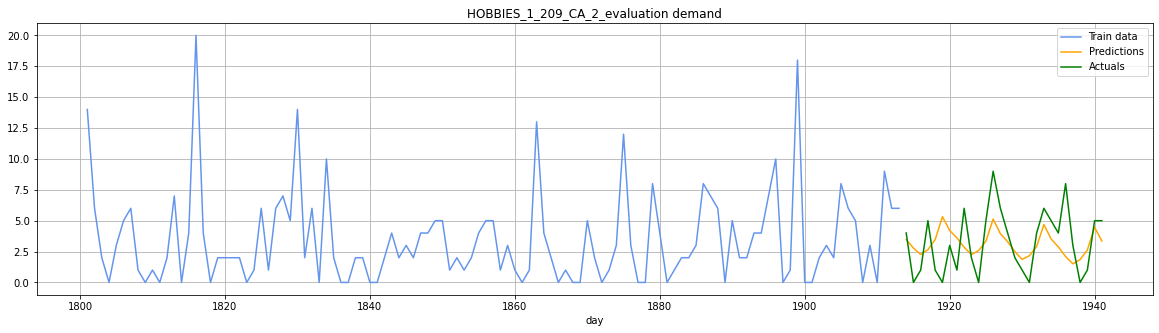

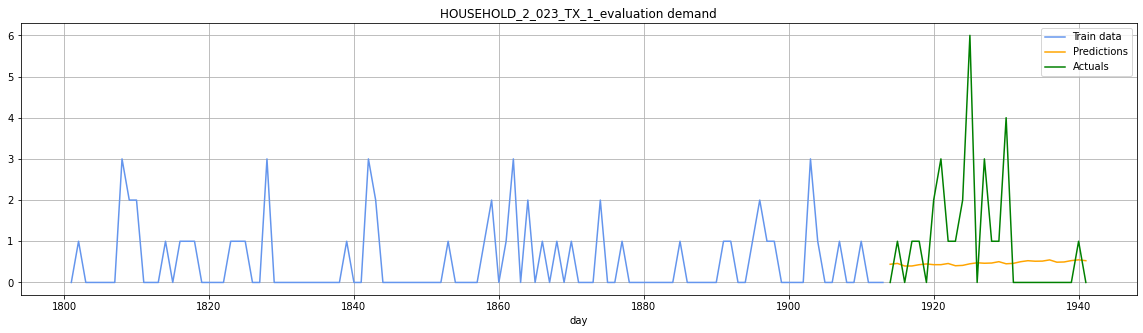

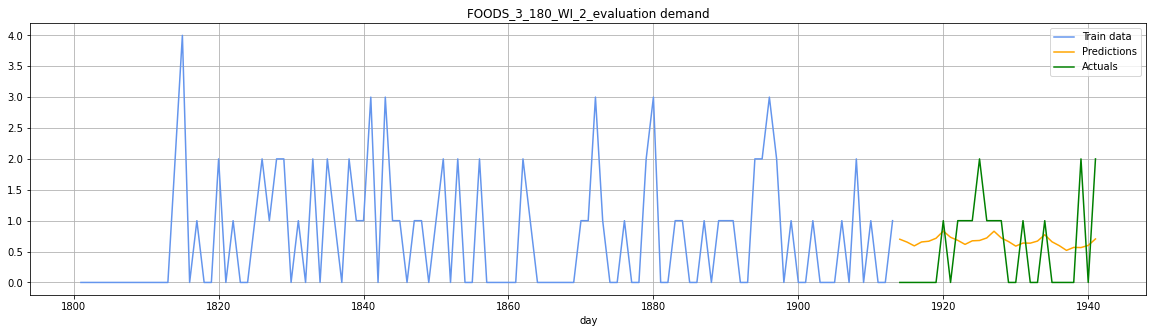

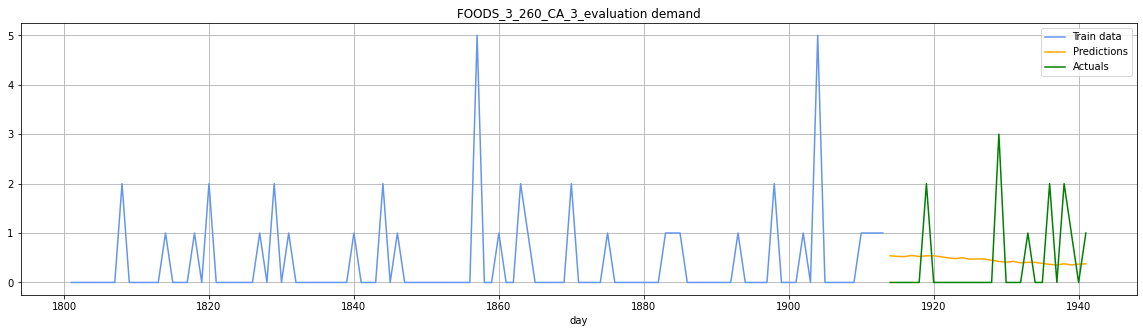

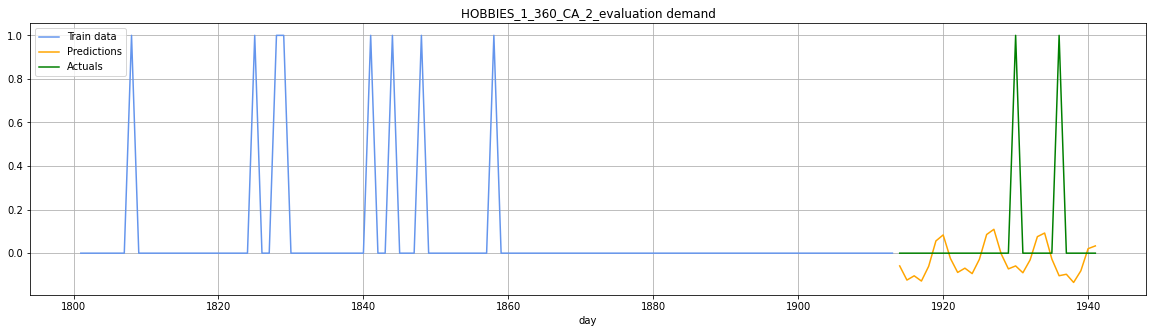

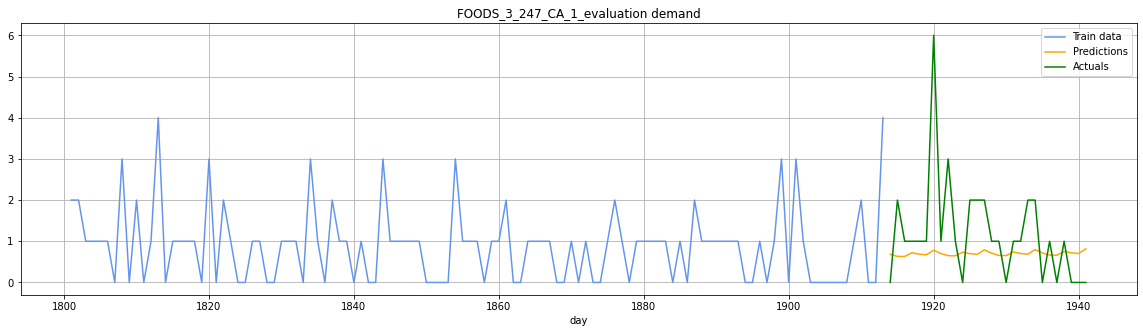

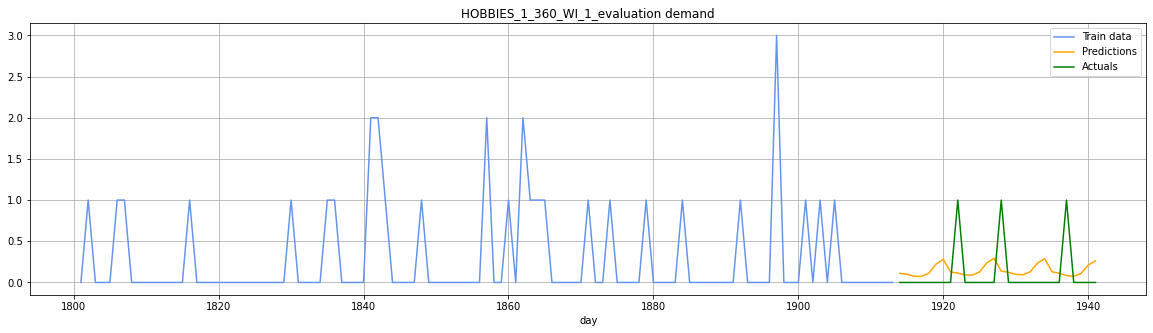

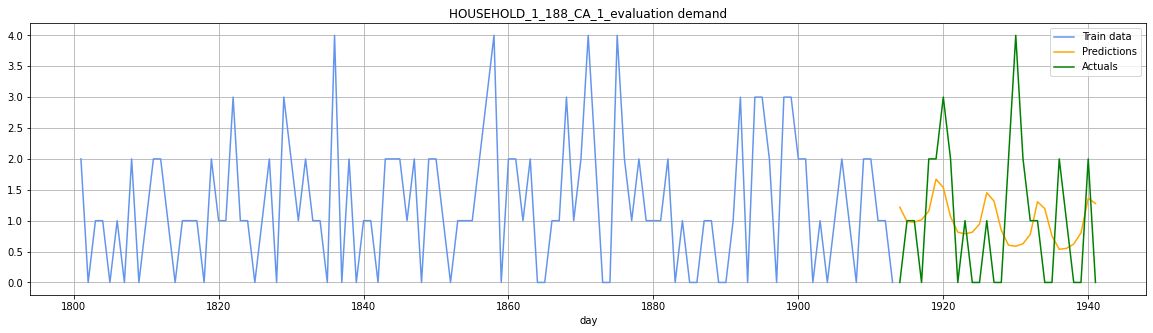

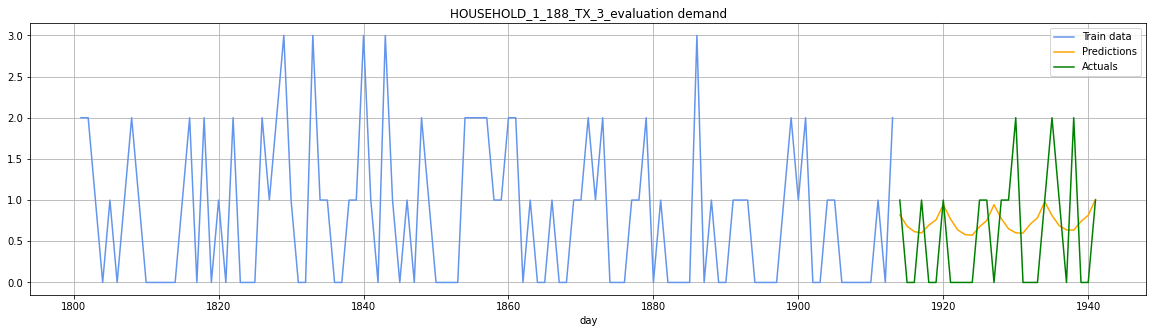

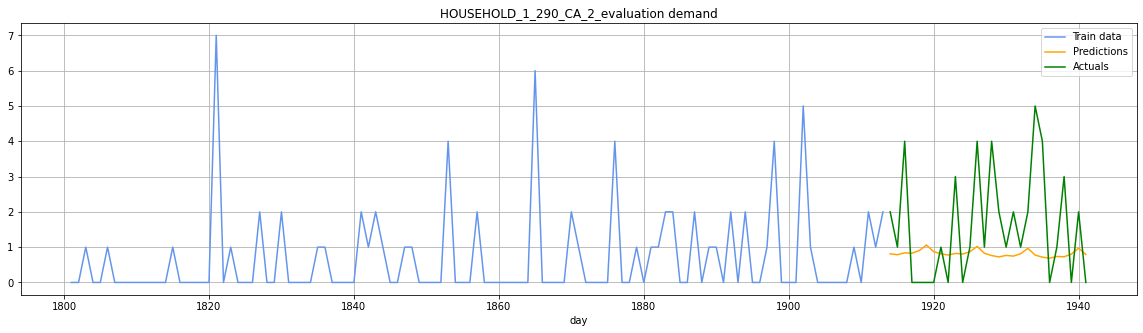

FBProphet Model test MSE is 1.56 and RMSE is 1.25
FBProphet Model test MSE for 10 sample is 1.56 and RMSE is 1.25


In [44]:
plot_predictions_for_sample(fbp_df, sample_items)

error = mean_squared_error(fbp_df['demand'], fbp_df['prediction'])
print(f'FBProphet Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

error = mean_squared_error(fbp_df[fbp_df.id.isin(sample_items)]['demand'], 
                           fbp_df[fbp_df.id.isin(sample_items)]['prediction'])
print(f'FBProphet Model test MSE for 10 sample is {error:.3} and RMSE is {error ** 0.5:.3}')

#### Observations

1. FB Prophet has performed better so far as compared to the traditional ARIMA SARIMA auto regressive algorithms
2. However, the model has also predicted some negative demands for the test period for item 'HOBBIES_1_360_CA_2_evaluation'
3. Prophet also suffers from the problem of training separate models and limits inter model learning capabilities

## Machine Learning Forecasting Techniques

To solve time series problems using machine learning approaches, we need to do some feature engineerings and make our data fit for the model. Machine learning model will solve this problem as a regression problem, however, there's one big difference between oridnary regression and time series regression.

Oridinary regression doesn't have a serial dependency between records, each record is independent of another record in the dataset. Time series problems have serial dependency between records, where observations of a later date is dependent with the observation of previous dates. 

For example, you may have a data set of house prices with features describing the houses including the year that house was built. Even though you have a date as a feature, this is not a time series problem. 

In time series forecasting, we are generally interested in predicting something that is changing over time, but in this data set, we have several different houses with one date and will be predicting the prices of other houses. So, this is a regression problem.
Another thing that may tell you that your problem is regression and not time series is if there isn’t really a relationship with your target and time. observations close to each other in time to be more similar than observations far away, after accounting for seasonality. For example, the weather today is usually more similar to the weather tomorrow than the weather a month from now. So, predicting the weather based on past weather observations is a time series problem.

Now we have got the understanding of the basic differences between the two, let's learn some feature engineering techniques to convert a time series problem to a regression problem -

- Autoregressive elements: lag variables
- Aggregated features on lagged variables: moving averages, exponential smoothing descriptive statistics, correlations
- Date-specific features: week number, day of week, month, year
- Target transformations: Integration/Differentiation, univariate transforms (like logs, square roots)


In [13]:
merged_data = pd.concat([train.drop('day', axis=1), test.drop('day', axis=1)], axis=0)

In [14]:
# time features

def basic_features(data):
  
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['year'] = data['year']-min(data['year'])
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek

    print('Time Features Finished.')

    return data

In [15]:
# Categorical data LabelEncoding
 
def transform(data):

    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])

    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']  
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])

    print('Data transformation finished')
    return data

In [16]:
# Lag and rolling feature engineering based on number of days of the weekly model

def simple_feat_demand(data, days):

    df = data.copy()
    sdays = days
    group = df.groupby('id')['demand']

    df['lag_ts0'] = group.transform(lambda x: x.shift(sdays))
    df['lag_ts1'] = group.transform(lambda x: x.shift(sdays+1))
    df['lag_ts2'] = group.transform(lambda x: x.shift(sdays+2))

    df['rolling_mean_t7'] = group.transform(lambda x: x.shift(sdays).rolling(7).mean())
    df['rolling_mean_t15'] = group.transform(lambda x: x.shift(sdays).rolling(15).mean())
    df['rolling_mean_t30'] = group.transform(lambda x: x.shift(sdays).rolling(30).mean())
    df['rolling_mean_t90'] = group.transform(lambda x: x.shift(sdays).rolling(90).mean())
    print('Rolling FE Finished.')

    df['rolling_std_t7'] = group.transform(lambda x: x.shift(sdays).rolling(7).std())
    df['rolling_std_t14'] = group.transform(lambda x: x.shift(sdays).rolling(14).std())
    df['rolling_std_t30'] = group.transform(lambda x: x.shift(sdays).rolling(30).std())
    df['rolling_std_t90'] = group.transform(lambda x: x.shift(sdays).rolling(90).std())
    df['rolling_skew_t12'] = group.transform(lambda x: x.shift(sdays).rolling(12).skew())
    df['rolling_skew_t16'] = group.transform(lambda x: x.shift(sdays).rolling(16).skew())
    df['rolling_skew_t21'] = group.transform(lambda x: x.shift(sdays).rolling(21).skew())
    df['rolling_skew_t5'] = group.transform(lambda x: x.shift(sdays).rolling(5).skew())
    print('SD FE Finished.')

    df['rolling_max_t7'] = group.transform(lambda x: x.shift(sdays).rolling(7).max())
    df['rolling_max_t14'] = group.transform(lambda x: x.shift(sdays).rolling(14).max())
    df['rolling_max_t30'] = group.transform(lambda x: x.shift(sdays).rolling(30).max())

    del group 
    print('Feature Engineering Finished.')

    return df

In [17]:
merged_data = basic_features(merged_data)
merged_data = transform(merged_data)
merged_data = merged_data.drop(['id_encode', 'date'], axis=1)
merged_data = simple_feat_demand(merged_data, 28)

Time Features Finished.
Data transformation finished
Rolling FE Finished.
SD FE Finished.
Feature Engineering Finished.


In [18]:
train_ml = merged_data.iloc[:len(train),:]
test_ml = merged_data.iloc[len(train):,:]

del merged_data
gc.collect()

0

In [19]:
train_ml.shape, test_ml.shape

((1893870, 30), (27720, 30))

In [20]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,46 days 20 hours 25 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,2 months and 13 days
H2O_cluster_name:,H2O_from_python_tarique_mcy6fk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.39 Gb
H2O_cluster_total_cores:,40
H2O_cluster_allowed_cores:,40
H2O_cluster_status:,"locked, healthy"


### 1. H2OXGBoostRegressor

In [49]:
from h2o.estimators import H2OXGBoostEstimator

def fit_h2o_xgb(df, df_test):
    
    data = h2o.H2OFrame(df.reset_index(drop=True))
    data_test = h2o.H2OFrame(df_test.reset_index(drop=True))
    
    lag_cols = ['lag_ts0', 'lag_ts1', 'lag_ts2', 'rolling_mean_t7', 'rolling_mean_t15', 'rolling_mean_t30',
                'rolling_mean_t90', 'rolling_std_t7', 'rolling_std_t14', 'rolling_std_t30', 'rolling_std_t90', 'rolling_skew_t12',
                'rolling_skew_t16', 'rolling_skew_t21', 'rolling_skew_t5', 'rolling_max_t7', 'rolling_max_t14', 
                'rolling_max_t30']
    
    for name in lag_cols:
        data[name] = data[name].ascharacter().asnumeric()
    
    train_cols = [col for col in data.columns if col not in ['id','demand']]
    
    model = H2OXGBoostEstimator(booster='dart',
                              normalize_type="tree",
                              seed=23123,
                              model_id = 'XGBoost', 
                              keep_cross_validation_predictions = False,
                              ntrees = 30, 
                              stopping_rounds = 30,
                              distribution = 'tweedie',
                              tweedie_power=1.1,
                              stopping_metric = "rmse"
                              )
    
    model_fit = model.train(x = train_cols, y = "demand", training_frame = data)
    pred = model_fit.predict(data_test).as_data_frame()['predict'].tolist()
    
    return pred


In [50]:
item_pred_xgb = fit_h2o_xgb(train_ml, test_ml)
test_ml['prediction_xgb'] = item_pred_xgb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [57]:
error = mean_squared_error(test_ml['demand'], test_ml['prediction_xgb'])
print(f'H2OXGBoost Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

error = mean_squared_error(test_ml[test_ml.id.isin(sample_items)]['demand'], 
                           test_ml[test_ml.id.isin(sample_items)]['prediction_xgb'])
print(f'H2OXGBoost Model test MSE for 10 sample is {error:.3} and RMSE is {error ** 0.5:.3}')

H2OXGBoost Model test MSE is 4.55 and RMSE is 2.13
H2OXGBoost Model test MSE for 10 sample is 1.5 and RMSE is 1.22


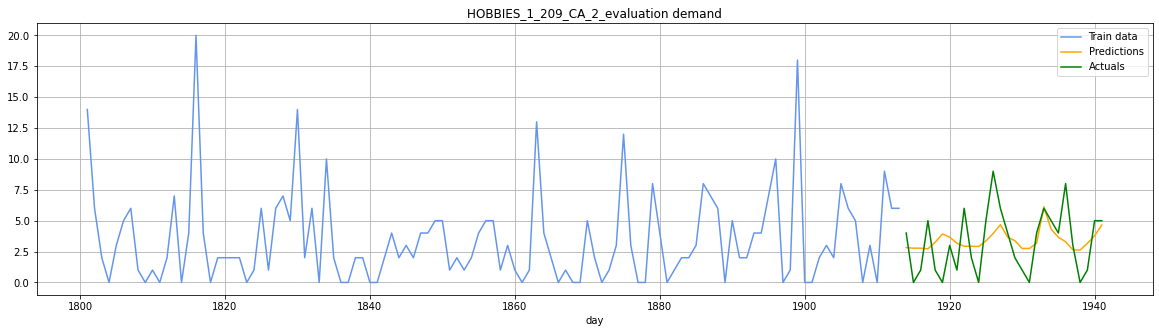

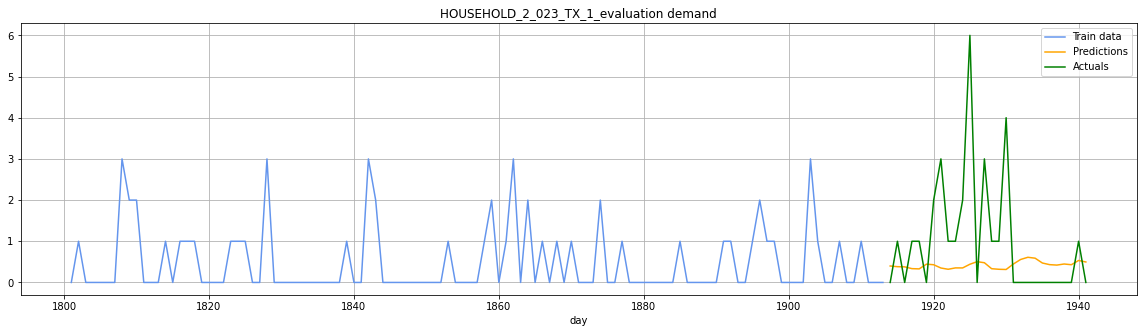

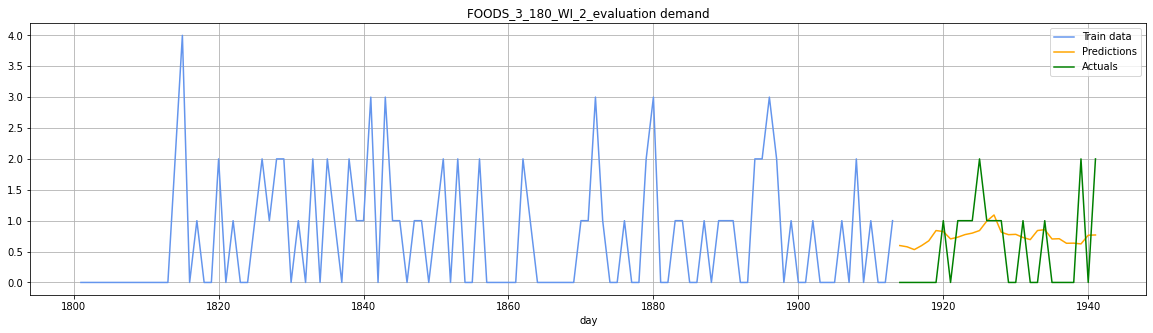

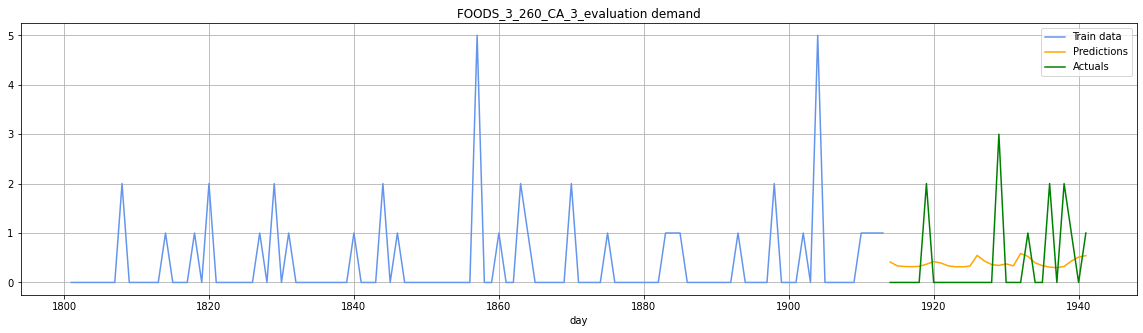

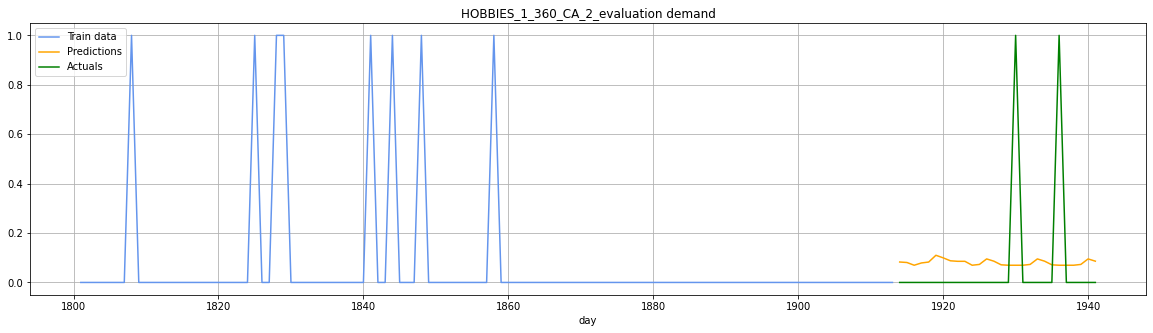

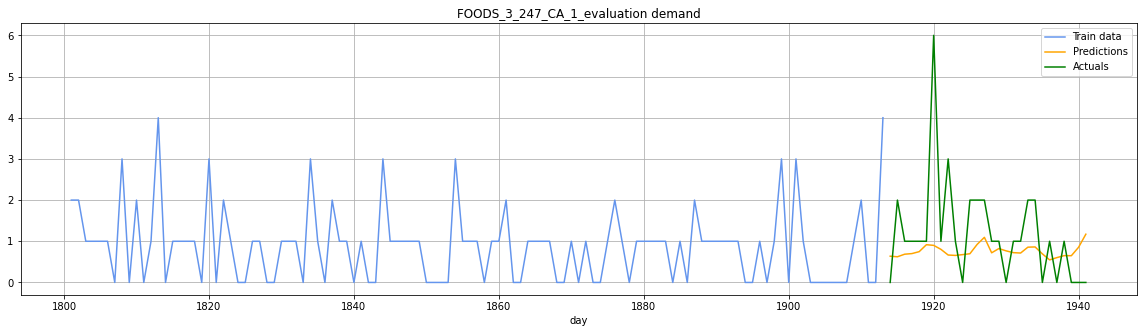

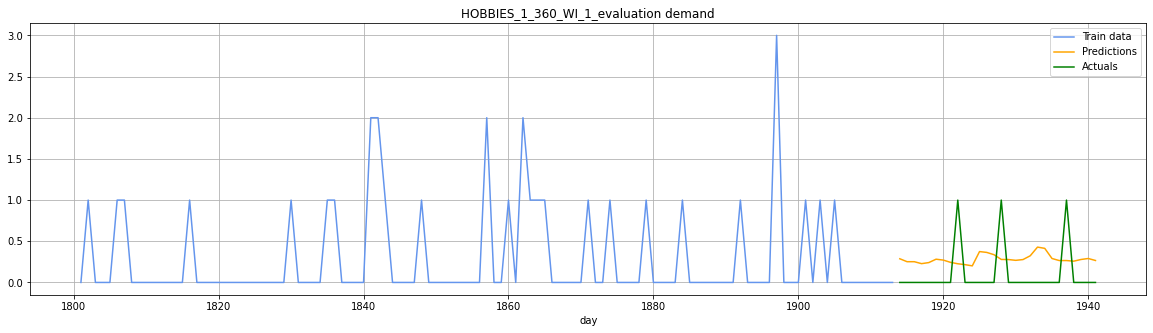

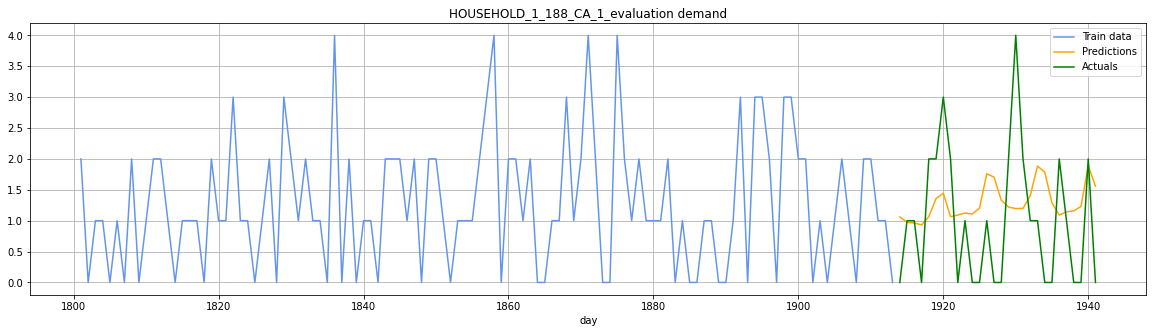

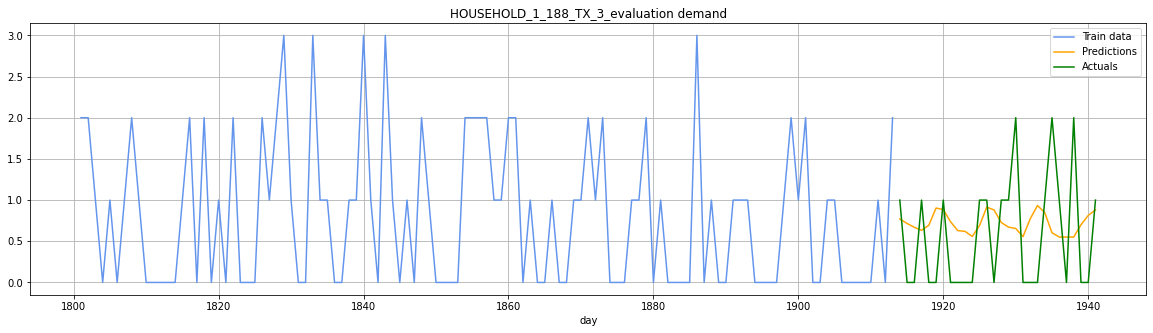

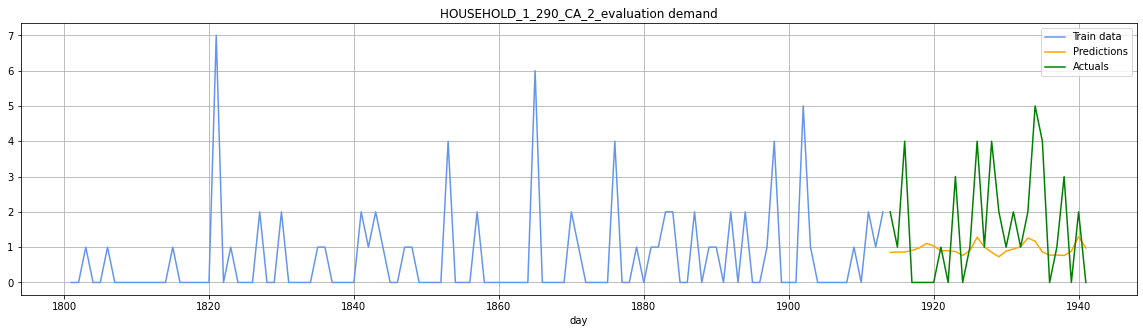

In [78]:
plot_predictions_for_sample(pd.concat([test, test_ml[['prediction_xgb']]], axis=1), 
                            sample_items, 'prediction_xgb')

### 2. H2ODeepLearningEstimator

In [65]:
from h2o.estimators import H2ODeepLearningEstimator

def fit_h2o_dl(df, df_test):
    
    data = h2o.H2OFrame(df.reset_index(drop=True))
    data_test = h2o.H2OFrame(df_test.reset_index(drop=True))
    
    lag_cols = ['lag_ts0', 'lag_ts1', 'lag_ts2', 'rolling_mean_t7', 'rolling_mean_t15', 'rolling_mean_t30',
                'rolling_mean_t90', 'rolling_std_t7', 'rolling_std_t14', 'rolling_std_t30', 'rolling_std_t90', 'rolling_skew_t12',
                'rolling_skew_t16', 'rolling_skew_t21', 'rolling_skew_t5', 'rolling_max_t7', 'rolling_max_t14', 
                'rolling_max_t30']
    
    for name in lag_cols:
        data[name] = data[name].ascharacter().asnumeric()
    
    train_cols = [col for col in data.columns if col not in ['id','demand']]
    
    model = H2ODeepLearningEstimator(distribution="tweedie",
                               hidden=[32, 32],
                               epochs=50,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               activation="Tanh",
                               seed=23123,
                               tweedie_power=1.5
                               )
    
    model_fit = model.train(x = train_cols, y = "demand", training_frame = data)
    pred = model_fit.predict(data_test).as_data_frame()['predict'].tolist()
    
    return pred


In [66]:
item_pred_dl = fit_h2o_dl(train_ml, test_ml)
test_ml['prediction_dl'] = item_pred_dl

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [67]:
error = mean_squared_error(test_ml['demand'], test_ml['prediction_dl'])
print(f'H2ODeepLearning Model test MSE is {error:.3} and RMSE is {error ** 0.5:.3}')

error = mean_squared_error(test_ml[test_ml.id.isin(sample_items)]['demand'], 
                           test_ml[test_ml.id.isin(sample_items)]['prediction_dl'])
print(f'H2ODeepLearning Model test MSE for 10 sample is {error:.3} and RMSE is {error ** 0.5:.3}')

H2ODeepLearning Model test MSE is 5.14 and RMSE is 2.27
H2ODeepLearning Model test MSE for 10 sample is 1.68 and RMSE is 1.3


In [76]:
def plot_predictions_for_sample(pred_df, sample_list, tcol):
    
    for item in sample_list:

        train[(train['id']==item) & (train.day>1800)].set_index('day')['demand'].plot(figsize=(20, 5), 
                                                                 color='cornflowerblue', label='Train data')
        pred_df[pred_df['id']==item].set_index('day')[tcol].plot(figsize=(20, 5), 
                                                                 color='orange', label='Predictions')
        pred_df[pred_df['id']==item].set_index('day')['demand'].plot(figsize=(20, 5), 
                                                                 color='green', label='Actuals')    
        plt.grid()
        plt.legend(loc = 'best')
        plt.title(f'{item} demand')
        plt.show(block=False)

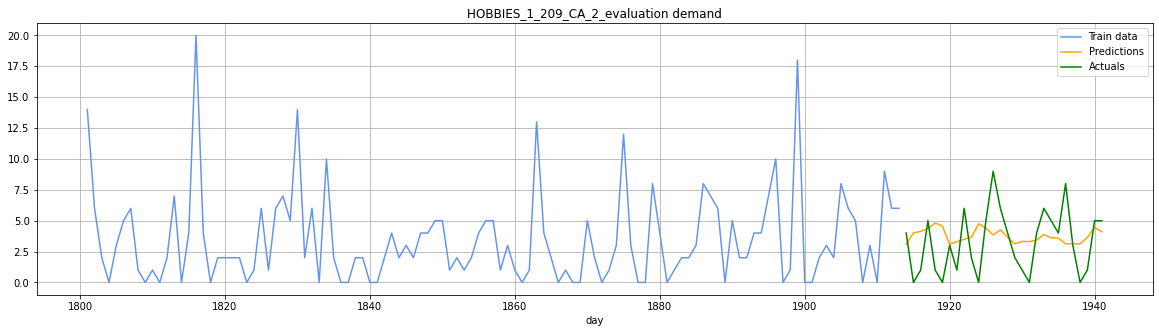

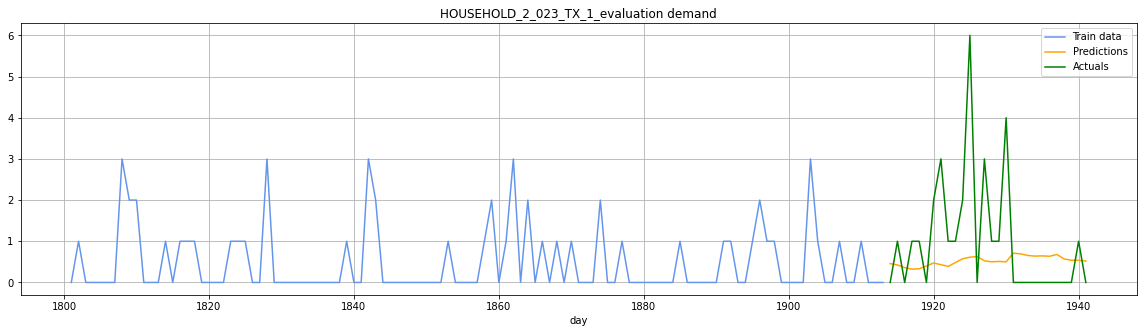

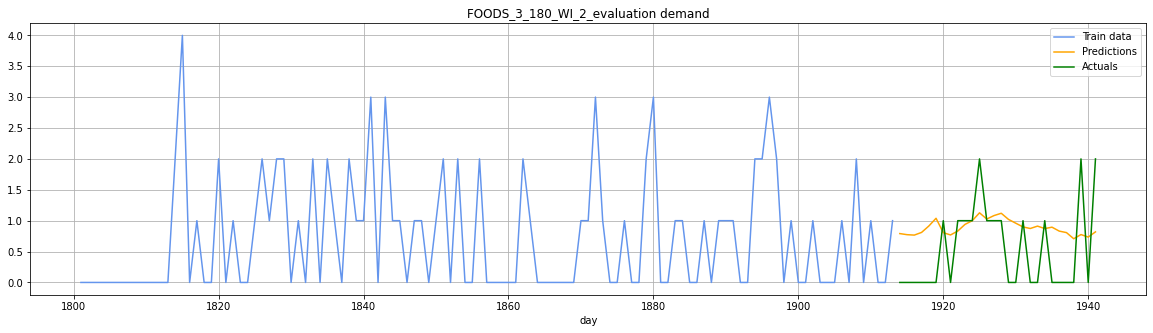

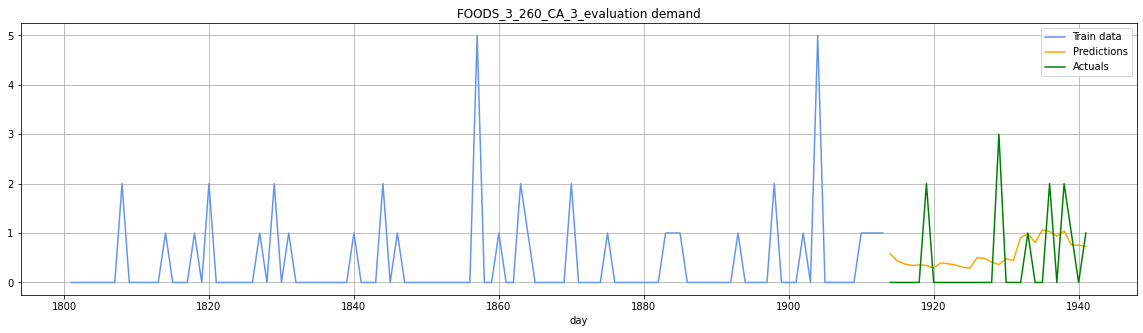

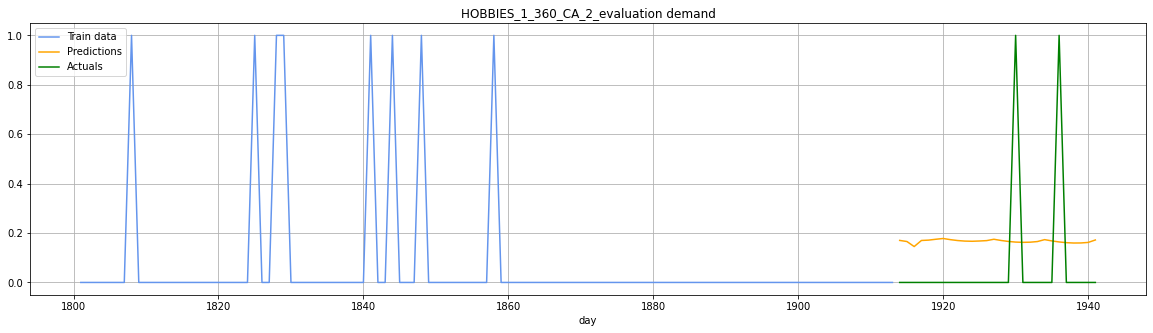

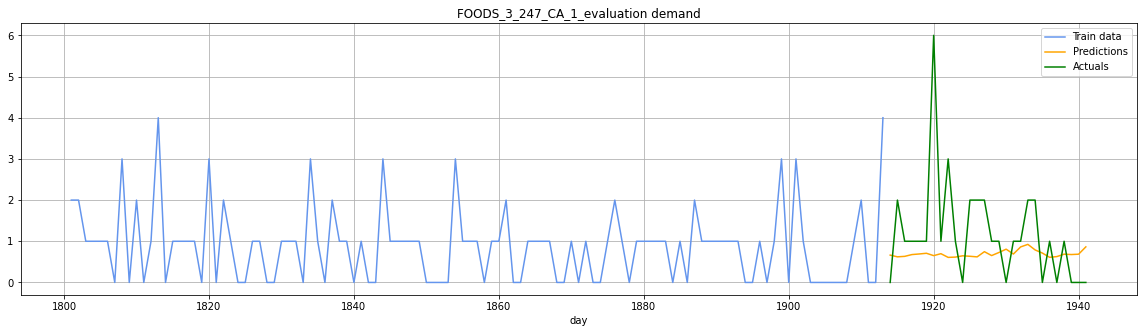

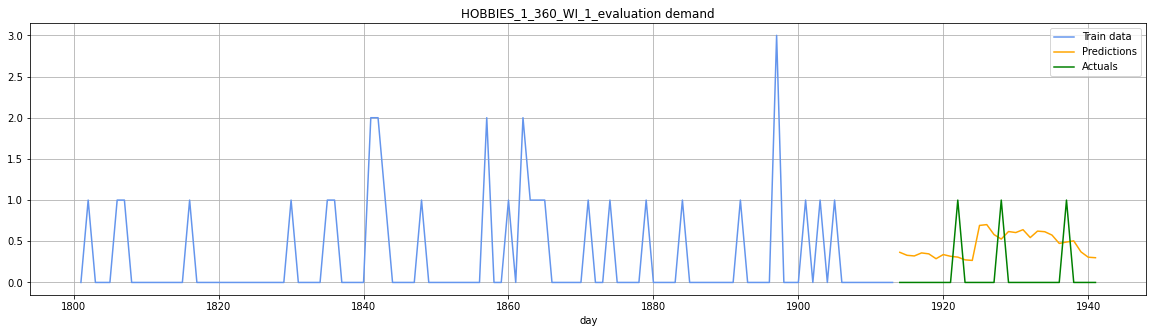

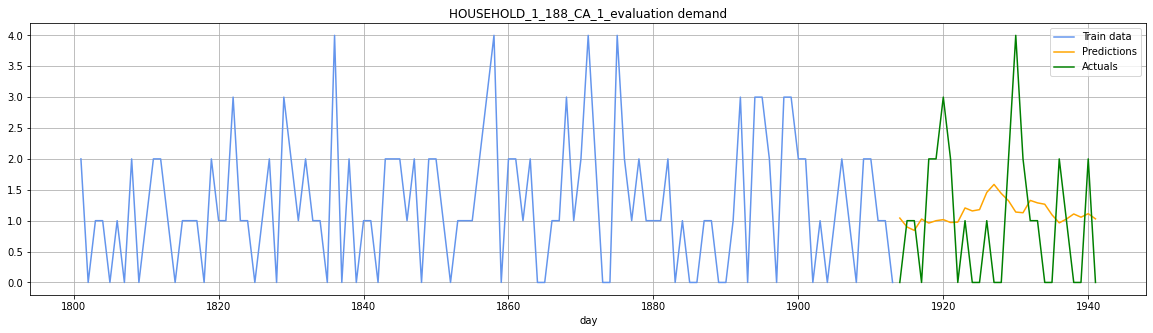

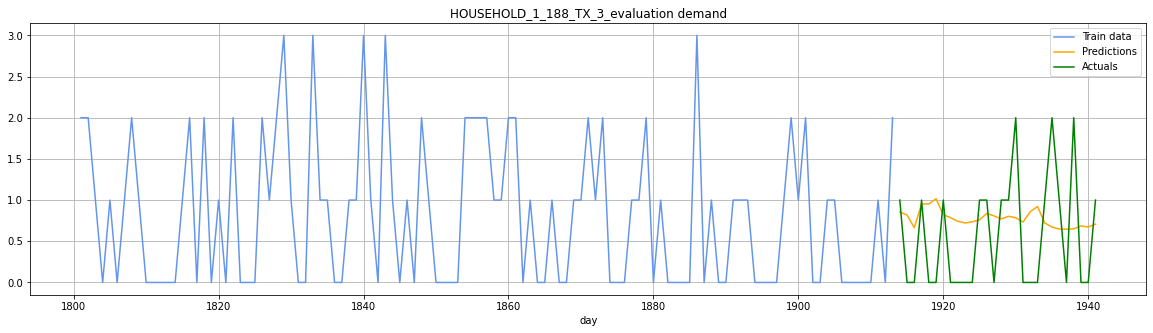

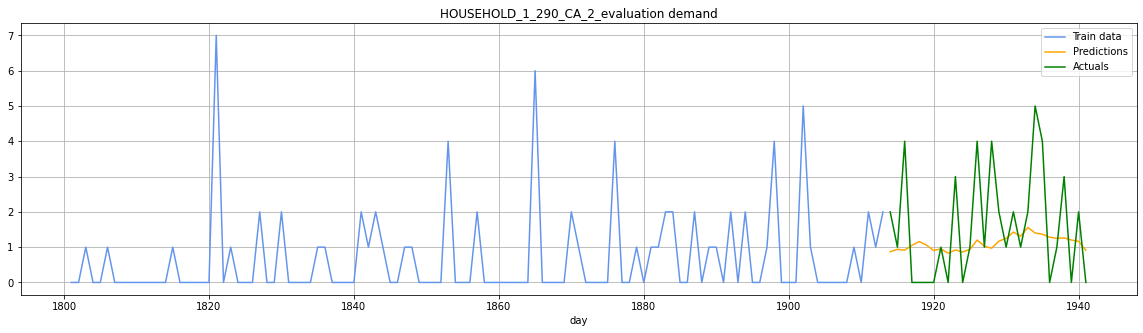

In [77]:
plot_predictions_for_sample(pd.concat([test, test_ml[['prediction_dl']]], axis=1), 
                            sample_items, 'prediction_dl')

#### Observations

1. Our out of the box H2OXGBoost model has outformed all the previous auto regressive based models (ARIMA, SARIMA and FBProphet) in just 30 iterations
2. We were successfully able to built one model which can fit for all unique items in the dataset with a better accuracy
3. H2ODeepLearning model has also performed quite well without any parameter tunings
4. Using a Machine Learning model provides us the edge for faster computation and better accuracy by learning interconnected feature properties of various timseries 